In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import calendar
import scipy
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import scipy
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import calendar
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

In [2]:
uploaded = files.upload()

Saving powerconsumption.csv to powerconsumption.csv


In [2]:
df = pd.read_csv('powerconsumption.csv')
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
Weekday = []
Day = []
Month = []
Year = []
Week = []
Hour = []
Min = []

for i in range(len(df)):
  Weekday.append(df['Datetime'].iloc[i].weekday())
  Day.append(df['Datetime'].iloc[i].day)
  Month.append(df['Datetime'].iloc[i].month)
  Year.append(df['Datetime'].iloc[i].year)
  Week.append(df['Datetime'].iloc[i].isocalendar()[1])
  Hour.append(df['Datetime'].iloc[i].hour)
  Min.append(df['Datetime'].iloc[i].minute)

df['Weekday'] = Weekday
df['Week'] = Week
df['Day'] = Day
df['Month'] = Month
df['Year'] = Year
df['Hour'] = Hour
df['Minute'] = Min

for i in range(150):
  if df['Datetime'].loc[i].date()==df['Datetime'].loc[0].date():
    df['Week'].iloc[i]=0

In [4]:
df.rename(columns={'WindSpeed': 'Wind', 'GeneralDiffuseFlows': 'GDF', 'DiffuseFlows': 'DF', 'PowerConsumption_Zone1': 'Zone1', 'PowerConsumption_Zone2': 'Zone2', 'PowerConsumption_Zone3': 'Zone3'}, inplace=True)
# df['Humidity'] = df['Humidity']/10
df['Zone1'] = df['Zone1']/1000
df['Zone2'] = df['Zone2']/1000
df['Zone3'] = df['Zone3']/1000

In [5]:
df['Total'] = df['Zone1']+df['Zone2']+df['Zone3']
df

,Datetime,Temperature,Humidity,Wind,GDF,DF,Zone1,Zone2,Zone3,Weekday,Week,Day,Month,Year,Hour,Minute,Total
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34.055696,16.128875,20.240964,6,0,1,1,2017,0,0,70.425535
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29.814684,19.375076,20.131084,6,0,1,1,2017,0,10,69.320844
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29.128101,19.006687,19.668434,6,0,1,1,2017,0,20,67.803222
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28.228861,18.361094,18.899277,6,0,1,1,2017,0,30,65.489232
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27.335696,17.872340,18.442410,6,0,1,1,2017,0,40,63.650446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31.160456,26.857318,14.780312,5,52,30,12,2017,23,10,72.798087
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30.430418,26.124578,14.428812,5,52,30,12,2017,23,20,70.983808
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29.590875,25.277693,13.806483,5,52,30,12,2017,23,30,68.675050
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28.958175,24.692237,13.512605,5,52,30,12,2017,23,40,67.163017


In [6]:
df['Time'] = [1]*len(df)
for i in range(len(df)):
  df['Time'].iloc[i] = df['Hour'].iloc[i]+round(df['Minute'].iloc[i]/60,2)

df['Time'] = df['Time'].astype('float')

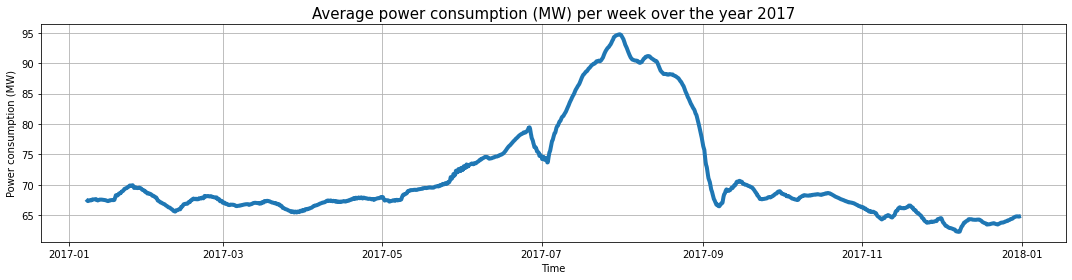

In [20]:
plt.figure(figsize=(15,4))

plt.plot(df['Datetime'], df['Total'].rolling(144*7).mean(), linewidth=4)
plt.xlabel('Time')
plt.ylabel('Power consumption (MW)')
plt.title('Average power consumption (MW) per week over the year 2017', fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

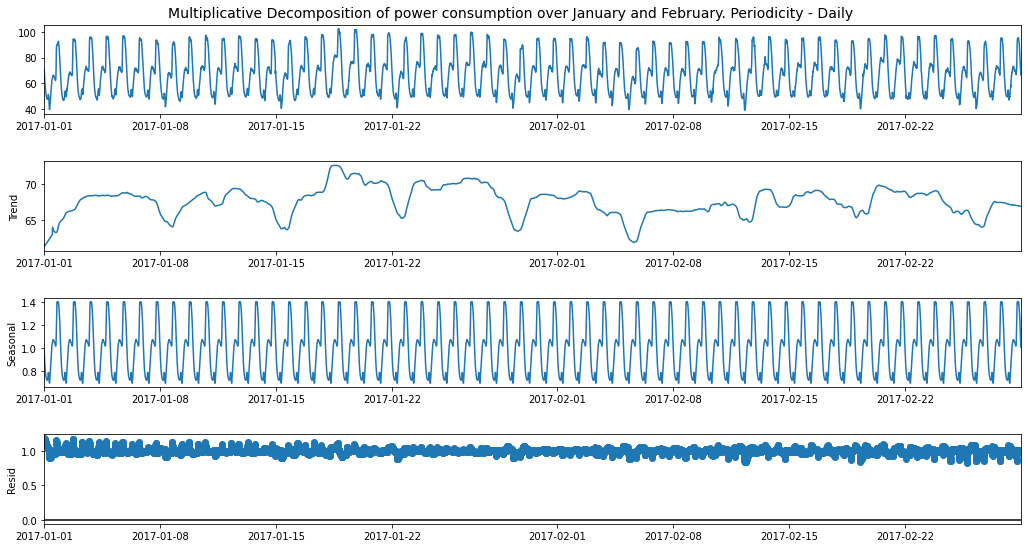

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams.update({'figure.figsize': (15,8)})

temp = df[df['Month']<3]
decom_df = temp[['Datetime', 'Total']]
# decom_df = decom_df.loc[:1000]
decom_df.set_index('Datetime', inplace=True)
result_mul = seasonal_decompose(decom_df, model='multiplicative', period=144, extrapolate_trend='freq')
result_mul.plot().suptitle('Multiplicative Decomposition of power consumption over January and February. Periodicity - Daily', fontsize=14)
plt.tight_layout(pad=3)
plt.show()


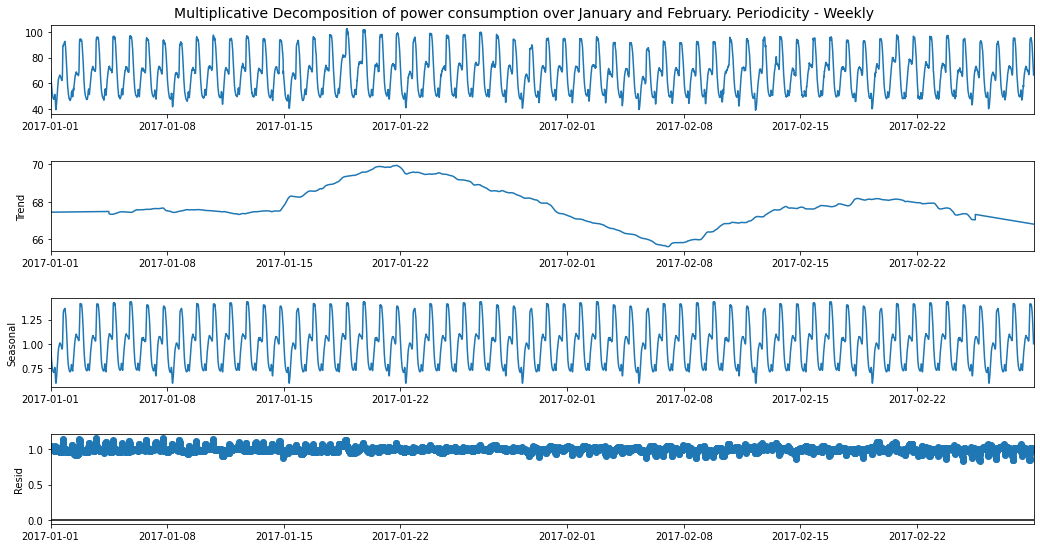

In [19]:
result_add = seasonal_decompose(decom_df, model='multiplicative', period=7*144, extrapolate_trend='freq')
result_add.plot().suptitle('Multiplicative Decomposition of power consumption over January and February. Periodicity - Weekly', fontsize=14)
plt.tight_layout(pad=3)

plt.show()

In [12]:
# plt.figure(figsize=(20,5))
# daily_df = df.groupby(['Year', 'Month', 'Day', 'Hour'], as_index=False).mean()

# axi = sns.boxplot(x='Time', y='Total', data=daily_df, showfliers=False)
# axi.set_xticklabels(axi.get_xticks())
# # ax.figure.autofmt_xdate()
# plt.show()

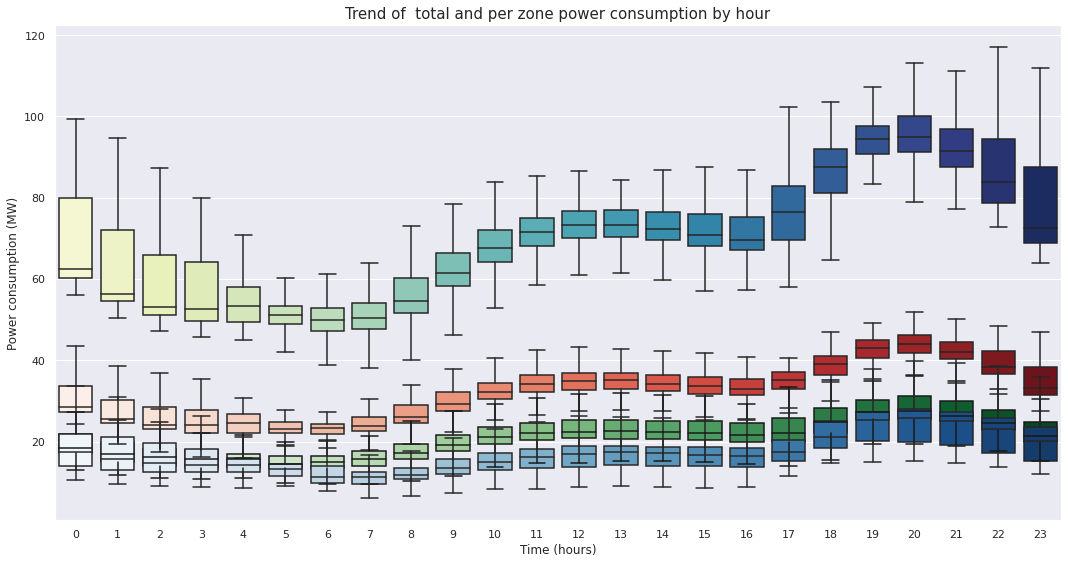

In [21]:
plt.figure(figsize=(15,8))
dy_df = df.groupby(['Year', 'Month', 'Day', 'Hour'], as_index=False).mean()
sns.set(style="darkgrid")
sns.boxplot(x='Time', y='Total', data=dy_df, showfliers=False, palette='YlGnBu')
sns.boxplot(x='Time', y='Zone1', data=dy_df, showfliers=False, palette='Reds')
sns.boxplot(x='Time', y='Zone2', data=dy_df, showfliers=False, dodge=False, palette='Greens')
a = sns.boxplot(x='Time', y='Zone3', data=dy_df, showfliers=False, dodge=False, palette='Blues')
a.set_xticklabels(a.get_xticks())
# ax.figure.autofmt_xdate()
plt.xlabel('Time (hours)')
plt.ylabel('Power consumption (MW)')
plt.title('Trend of  total and per zone power consumption by hour', fontsize=15)
plt.tight_layout()

plt.show()

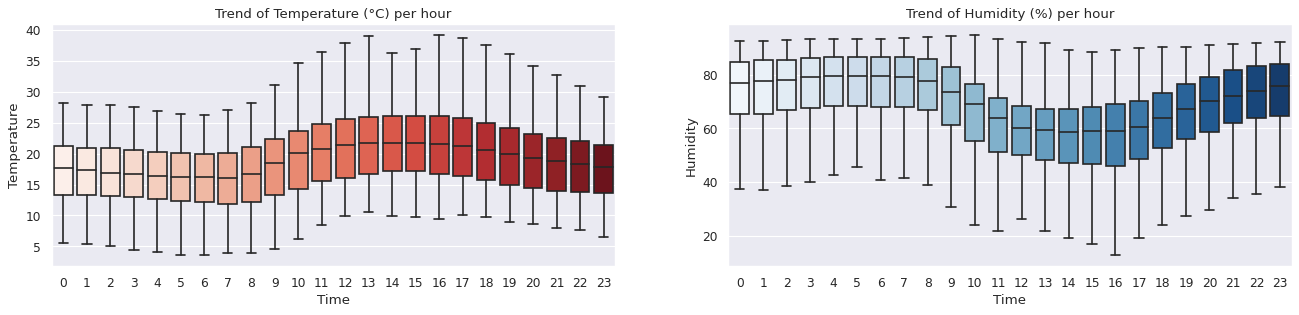

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,4), dpi= 80)

a1 = sns.boxplot(x='Time', y='Temperature', data=dy_df, showfliers=False, ax=axes[0], palette='Reds')
a2 = sns.boxplot(x='Time', y='Humidity', data=dy_df, showfliers=False, ax=axes[1], palette='Blues')

a1.set_xticklabels(a1.get_xticks())
a1.set_title('Trend of Temperature (°C) per hour', fontsize=12)
a2.set_xticklabels(a2.get_xticks())
a2.set_title('Trend of Humidity (%) per hour', fontsize=12)
# plt.tight_layout()

plt.show()

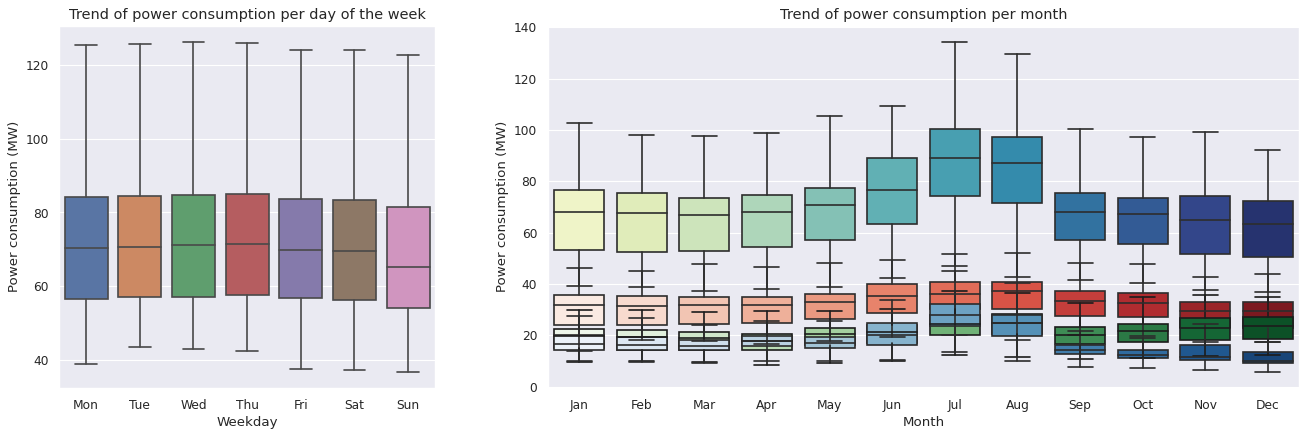

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20,6), dpi= 80, gridspec_kw={'width_ratios': [1, 2]})
sns.set(style="darkgrid")
wkdy = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
cr = sns.boxplot(x='Weekday', y='Total', data=df, showfliers=False, ax=axes[0])
cr.set_ylabel('Power consumption (MW)')
cr.set_xticklabels([wkdy[x] for x in cr.get_xticks()])
cr.set_title('Trend of power consumption per day of the week', fontsize=13)

sns.boxplot(x='Month', y='Total', data=df, showfliers=False, ax=axes[1], palette='YlGnBu')
sns.boxplot(x='Month', y='Zone1', data=df, showfliers=False, ax=axes[1], palette='Reds', dodge=True)
sns.boxplot(x='Month', y='Zone2', data=df, showfliers=False, ax=axes[1], palette='Greens', dodge=True)
br = sns.boxplot(x='Month', y='Zone3', data=df, showfliers=False, ax=axes[1], palette='Blues', dodge=True)
br.set_ylabel('Power consumption (MW)')
br.set_xticklabels([calendar.month_abbr[x+1] for x in br.get_xticks()])
br.set_title('Trend of power consumption per month', fontsize=13)
# plt.tight_layout()

plt.show()

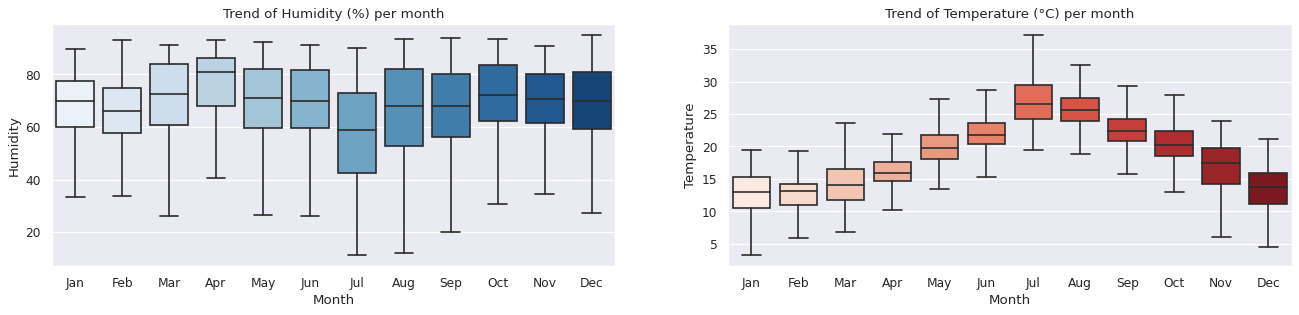

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20,4), dpi= 80)

ab1 = sns.boxplot(x='Month', y='Humidity', data=df, showfliers=False, ax=axes[0], palette='Blues')
ab2 = sns.boxplot(x='Month', y='Temperature', data=df, showfliers=False, ax=axes[1], palette='Reds')

# a1.set_xticklabels(a1.get_xticks())
# a2.set_xticklabels(a2.get_xticks())

ab2.set_title('Trend of Temperature (°C) per month', fontsize=12)
ab2.set_xticklabels([calendar.month_abbr[x+1] for x in ab2.get_xticks()])

ab1.set_title('Trend of Humidity (%) per month', fontsize=12)
ab1.set_xticklabels([calendar.month_abbr[x+1] for x in ab1.get_xticks()])


plt.show()

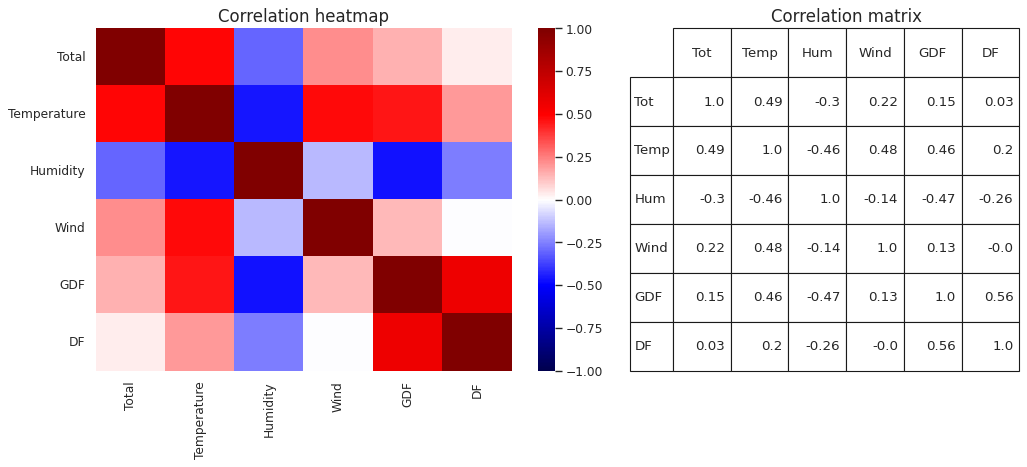

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(13,6), dpi= 80, gridspec_kw={'width_ratios': [1.5, 1]})

sns.heatmap(df[['Total', 'Temperature', 'Humidity', 'Wind', 'GDF', 'DF']].corr(), cmap='seismic', ax=axes[0], vmin=-1)
axes[0].set_title('Correlation heatmap', fontsize=15)

corr_m = round(df[['Total', 'Temperature', 'Humidity', 'Wind', 'GDF', 'DF']].corr(),2)
axes[1].axis('off')
corr_labels = ['Tot', 'Temp', 'Hum', 'Wind', 'GDF', 'DF']
mpl_table = axes[1].table(cellText=corr_m.values, rowLabels=corr_labels, bbox=[0,0,1,1], colLabels=corr_labels, fontsize=20)
axes[1].set_title('Correlation matrix', fontsize=15)
plt.tight_layout()

plt.show()

In [28]:
def high_low(data, feature):
  tempdf = data.groupby(['Month'], as_index=False).mean().sort_values([feature], ascending=False)
  tempdf = tempdf[['Month', feature]]
  mname = [calendar.month_name[x] for x in tempdf['Month']]
  tempdf['Month_name'] = mname
  tempdf.set_index('Month', inplace=True)
  return tempdf

In [29]:
from IPython.display import display_html 

tm_df = high_low(df, 'Temperature')
hm_df = high_low(df, 'Humidity')
pw_df = high_low(df, 'Total')
wn_df = high_low(df, 'Wind')

df1_styler = pw_df.style.set_table_attributes("style='display:inline'").set_caption('Total power consumption (MW)')
df2_styler = tm_df.style.set_table_attributes("style='display:inline'").set_caption('Temperature (°C)')
df3_styler = hm_df.style.set_table_attributes("style='display:inline'").set_caption('Humidity (%)')
df4_styler = wn_df.style.set_table_attributes("style='display:inline'").set_caption('Wind speed (Km/h)')

spc = '&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp'

display_html(df1_styler._repr_html_()+spc+df2_styler._repr_html_()+spc+df3_styler._repr_html_()+spc+df4_styler._repr_html_(), raw=True)


,Total,Month_name
Month,,
7,88.173552,July
8,85.740301,August
6,75.707411,June
5,69.994398,May
9,68.499912,September
1,68.173034,January
10,67.560749,October
4,67.396902,April
2,67.108549,February


In [30]:
train = df[df['Month']<=11]
test = df[df['Month']>11]

features = ['Temperature', 'Humidity', 'Wind', 'GDF', 'DF', 'Weekday', 'Week', 'Day', 'Month', 'Year', 'Hour', 'Minute']
values = ['Total']

x_train = train[features]
y_train = train[values]

x_test = test[features]
y_test = test[values]

x_val = test['Datetime']

In [45]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=900,
                       early_stopping_rounds=100,
                       objective='reg:squarederror',
                       max_depth=10,
                       learning_rate=0.1)
reg.fit(x_train, y_train,         
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:66.1401	validation_1-rmse:58.1267
[100]	validation_0-rmse:0.670939	validation_1-rmse:2.49529
[200]	validation_0-rmse:0.496769	validation_1-rmse:2.51022
[300]	validation_0-rmse:0.385574	validation_1-rmse:2.50872
[400]	validation_0-rmse:0.317384	validation_1-rmse:2.50336
[500]	validation_0-rmse:0.271237	validation_1-rmse:2.50809
[600]	validation_0-rmse:0.232113	validation_1-rmse:2.50449
[700]	validation_0-rmse:0.197315	validation_1-rmse:2.50387
[800]	validation_0-rmse:0.168878	validation_1-rmse:2.5062
[899]	validation_0-rmse:0.143851	validation_1-rmse:2.50673


XGBRegressor(early_stopping_rounds=100, max_depth=10, n_estimators=900,
             objective='reg:squarederror')

In [46]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=x_train.columns,
             columns=['importance'])

In [47]:
fi

,importance
Temperature,0.038353
Humidity,0.000805
Wind,0.000882
GDF,0.006345
DF,0.000982
Weekday,0.014291
Week,0.104039
Day,0.004944
Month,0.201716
Year,0.000000


In [48]:
y_pred = reg.predict(x_test)

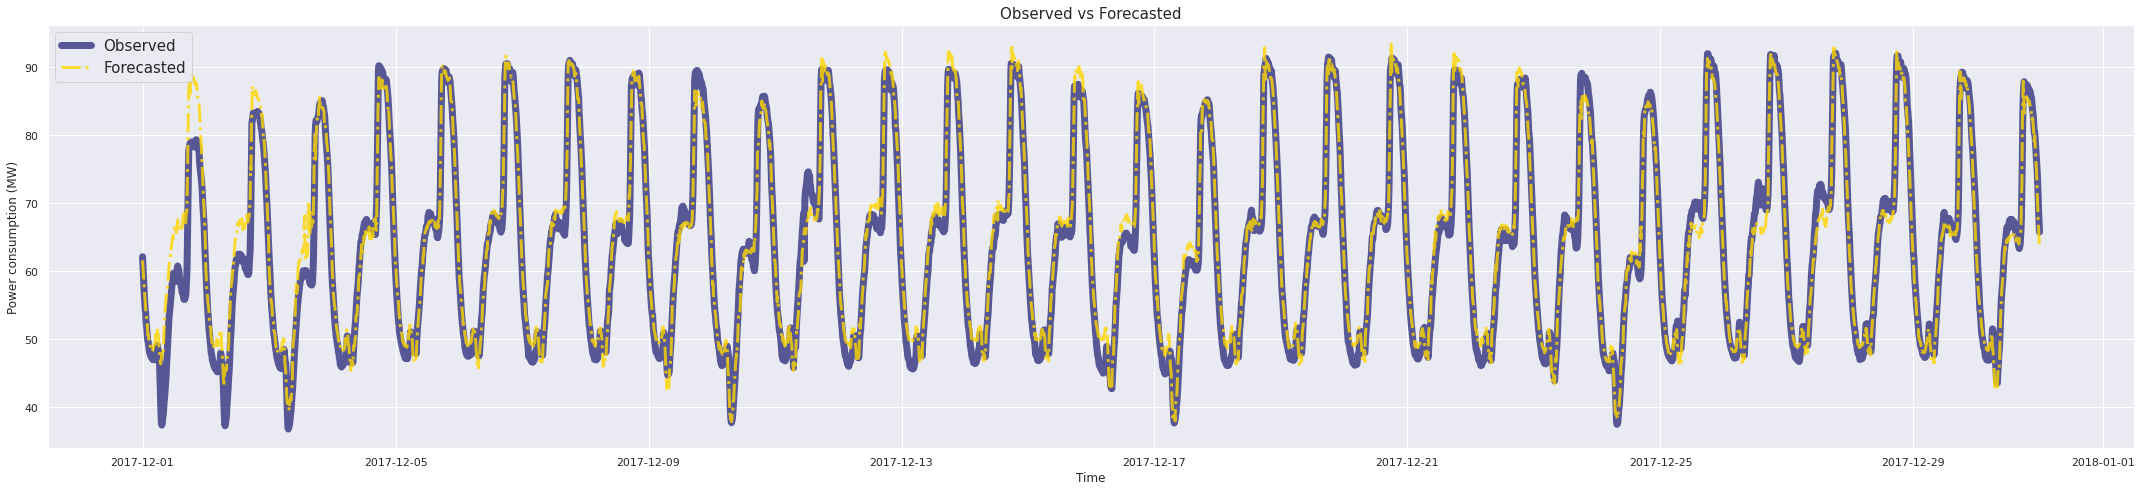

In [63]:
plt.figure(figsize=(30,7))
sns.set_style("darkgrid")
# plt.plot(df['Datetime'], df['Total'], color='blue', alpha=0.7)
plt.plot(x_val, y_test, color='midnightblue', alpha=0.7, linewidth=7, label='Observed')
plt.plot(x_val, y_pred, color='gold', alpha=0.8, linewidth=3, linestyle='dashdot', label='Forecasted')
plt.xlabel('Time')
plt.ylabel('Power consumption (MW)')
plt.title('Observed vs Forecasted', fontsize=15)
plt.tight_layout()
plt.legend(loc=2, fontsize=15)

plt.show()

In [36]:
mean_squared_error(y_test, y_pred)

6.959948849704078

In [ ]:
n = int((10/11)*(len(x_train)))
rs_xtrain = x_train.loc[:n-1]
rs_ytrain = y_train.loc[:n-1]
rs_xtest = x_train.loc[n:]
rs_ytest = y_train.loc[n:]

h_params = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'mse'])
hpi = 0

for i in range(500, 1600, 200):
  for j in np.linspace(0.1, 0.4, 5):
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                          n_estimators=i,
                          early_stopping_rounds=100,
                          objective='reg:squarederror',
                          learning_rate=j)


    reg.fit(rs_xtrain, rs_ytrain,         
            eval_set=[(rs_xtrain, rs_ytrain), (rs_xtest, rs_ytest)],
            verbose=100)

    rs_ypred = reg.predict(rs_xtest)

    ms_err = mean_squared_error(rs_ytest, rs_ypred)
    h_params.loc[hpi] = [i, j, ms_err]
    hpi+=1

In [ ]:
h_params.sort_values('mse')